In [1]:
# default_exp utils

# Utils

> Utility functions

In [2]:
#hide

# documentation extraction for class methods
from nbdev.showdoc import *

# unit tests using test_eq(...)
from fastcore.test import *

# monkey patching class methods using @patch
from fastcore.foundation import *
from fastcore.foundation import patch

# imitation of Julia's multiple dispatch using @typedispatch
from fastcore.dispatch import typedispatch

In [3]:
#export
import json
import numpy as np
import matplotlib.pyplot as plt



## Storing/Loading Settings
Sensor calibration settings are stored in a dictionary. 

In [13]:
openhsi_settings = {
    "version":1,
    "smile_cor":"wave_cal.pkl",
    "row_slice":(0,-1), # start and end rows to crop
    "col_slice":(0,-1), # ditto for cols
}

with open('calibration_files/settings.txt', 'w') as outfile:
    json.dump(openhsi_settings, outfile)
    
with open('calibration_files/settings.txt') as json_file:
    openhsi_settings = json.load(json_file)

array([0., 0., 0., 0., 0.])

## Abstration for Writing Hyperspectral Lines to a Buffer

The buffer updates the array write position automatically

In [4]:
#export

class CircArrayBuffer():
    """Circular Buffer implementation on ndarrays. Each push is a (n-1)darray. 
    The insert axis can be specified and modified after initialisation using `update_axis`."""
    
    def __init__(self,size:tuple=(100,100),axis:int=0,dtype=np.uint16,show_func=None):
        """initialise array and write pointer"""
        self.data = np.zeros(size,dtype=dtype)
        self.size = size
        self.axis = axis
        self.write_pos = [slice(None,None,None) if i != axis else 0 for i in range(len(size)) ]
        self.show_func = show_func
        
    def __getitem__(self,key):
        return self.data[key]

@patch
def update_axis(self:CircArrayBuffer, axis, write_pos=0):
    """changes the write axis in array"""
    self.axis = axis
    self.write_pos = [slice(None,None,None) if i != axis else write_pos for i in range(len(self.size)) ]

@patch
def push(self:CircArrayBuffer,line):
    """writes a (n-1)darray into the ndarray"""
    self.data[tuple(self.write_pos)] = line

    self.write_pos[self.axis] += 1
    if self.write_pos[self.axis] == self.size[self.axis]:
        self.write_pos[self.axis] = 0
        # write data to file

@patch
def show(self:CircArrayBuffer):
    """Display the data"""
    if self.show_func is None:
        if len(self.size) == 2:
            plt.imshow(self.data,cmap='gray')
            plt.show()
        elif len(self.size) == 3:
            plt.imshow(np.sum(self.data,axis=-1),cmap='gray')
            plt.show()
        elif len(self.size) == 1:
            print(f"#({self.size[0]}) {self.data}")
    elif self.show_func is not None:
        self.show_func(self.data)
    else:
        print("Unsupported array shape. Please use 2D or 3D shapes or use your own custom show function")

@patch
def dump(self:CircArrayBuffer,fname:str):
    if ".nc" in fname:
        pass
    else:
        with open(fname,'wb') as handle:
            pickle.dump(self.data,handle)

@patch
def load(self:CircArrayBuffer,fname:str):
    if ".nc" in fname:
        pass
    else:
        with open(fname,'rb') as handle:
            self.data = pickle.load(handle)
    self.size = np.shape(self.data)
    self.write_pos = [slice(None,None,None) if i != axis else 0 for i in range(len(size)) ]



For example, we can write to a 1D array

In [5]:
cib = CircArrayBuffer(size=(7,),axis=0)
for i in range(9):
    cib.push(i)
    cib.show()

#(7) [0 0 0 0 0 0 0]
#(7) [0 1 0 0 0 0 0]
#(7) [0 1 2 0 0 0 0]
#(7) [0 1 2 3 0 0 0]
#(7) [0 1 2 3 4 0 0]
#(7) [0 1 2 3 4 5 0]
#(7) [0 1 2 3 4 5 6]
#(7) [7 1 2 3 4 5 6]
#(7) [7 8 2 3 4 5 6]


Or a 2D array and even update the write axis midway through.

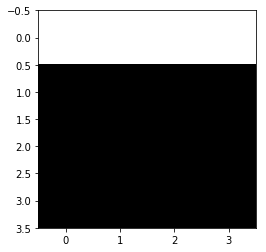

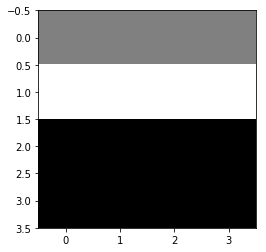

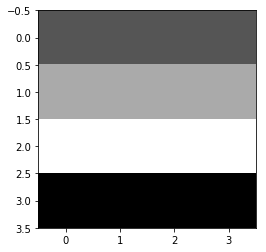

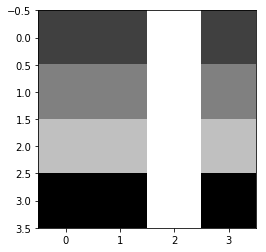

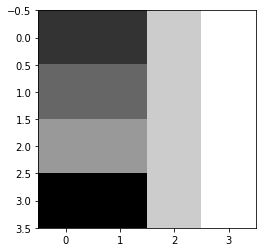

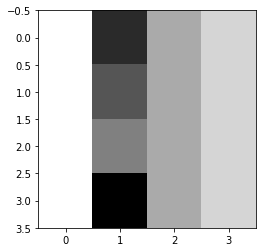

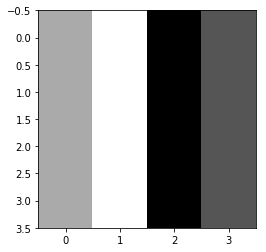

In [6]:
cib = CircArrayBuffer(size=(4,4),axis=0)
for i in range(7):
    cib.push(i+1) # scalars are broadcasted to a 1D array
    cib.show()
    
    if i == 2:
        cib.update_axis(1,write_pos=2)

## Smile Correction




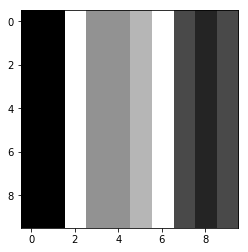

In [7]:
shifts = np.random.randint(0,4,10)

cib = CircArrayBuffer(size=(10,10),axis=1)
for i in range(10):
    cib.push(np.random.randint(10))

class Shifter():
    def __init__(self,shifts,line_len,dtype=np.uint16):
        self.shifts   = shifts
        self.line_len = line_len
        self.data = np.zeros((len(shifts),line_len),dtype=dtype)
    
    def __call__(self,line):
        
        for i in range(len(self.shifts)):
            self.data[i,...] = line[i,self.shifts[i]:self.shifts[i]+self.line_len]
        
        return self.data
    
st = Shifter(shifts,6)

cib.show()

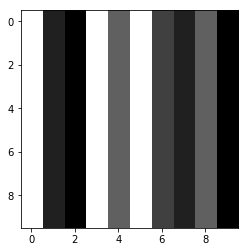

In [8]:
cib2 = CircArrayBuffer(size=(10,10),axis=1)
for i in range(10):
    cib2.push(np.random.randint(10))
cib2.show()

In [9]:
print(st.shifts)

[0 3 0 3 1 0 2 1 0 3]


In [10]:
st(cib2.data)

array([[8, 1, 0, 8, 3, 8],
       [8, 3, 8, 2, 1, 3],
       [8, 1, 0, 8, 3, 8],
       [8, 3, 8, 2, 1, 3],
       [1, 0, 8, 3, 8, 2],
       [8, 1, 0, 8, 3, 8],
       [0, 8, 3, 8, 2, 1],
       [1, 0, 8, 3, 8, 2],
       [8, 1, 0, 8, 3, 8],
       [8, 3, 8, 2, 1, 3]], dtype=uint16)